In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-5b542df5-6de6-e6a5-ea73-d86ace4c1aa7)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir -p /content/dataset/ /content/models/slide_classifier

In [4]:
!pip install -U optuna pytorch_lightning efficientnet_pytorch pytorch-ranger wandb

     |████████████████████████████████| 235kB 4.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 409kB 9.1MB/s 
     |████████████████████████████████| 1.6MB 11.7MB/s 
     |████████████████████████████████| 81kB 9.6MB/s 
     |████████████████████████████████| 163kB 31.5MB/s 
     |████████████████████████████████| 829kB 28.5MB/s 
     |████████████████████████████████| 276kB 40.2MB/s 
     |████████████████████████████████| 2.8MB 45.7MB/s 
     |████████████████████████████████| 102kB 10.9MB/s 
     |████████████████████████████████| 122kB 48.6MB/s 
     |████████████████████████████████| 102kB 11.7MB/s 
     |████████████████████████████████| 163kB 47.1MB/s 
     |████████████████████████████████| 133kB 45.0MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
     |████████████████████████████████| 112kB 55.6MB/s 
     |████████████████████████████████| 

In [5]:
!wandb login d40f31291558cdf328a54db5fe5d161874e273ec

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [6]:
!tar xf "/content/drive/My Drive/classifier-data-cv.tar.xz" -C /content/dataset/

In [7]:
%cd models/slide_classifier

/content/models/slide_classifier


In [8]:
from slide_classifier_pytorch import SlideClassifier

In [9]:
import torch
import optuna
import numpy as np
from argparse import Namespace

from pytorch_lightning import loggers
from pytorch_lightning import Trainer

In [10]:
cv_splits = [
    (
        "../../dataset/classifier-data-cv/split_0,../../dataset/classifier-data-cv/split_1",
        "../../dataset/classifier-data-cv/split_2"
    ),
    (
        "../../dataset/classifier-data-cv/split_1,../../dataset/classifier-data-cv/split_2",
        "../../dataset/classifier-data-cv/split_0"
    ),
    (
        "../../dataset/classifier-data-cv/split_0,../../dataset/classifier-data-cv/split_2",
        "../../dataset/classifier-data-cv/split_1"
    ),
]

In [11]:
def objective(trial):
    accuracies = []
    
    for idx, (train_split, val_split) in enumerate(cv_splits):
        print("Training split %i/%i" % (idx, len(cv_splits)))
        
        hparams = Namespace(
            amp_level="O1",
            arch=trial.suggest_categorical('hparams_arch', ['efficientnet-b0', 'resnet34']),
            auto_lr_find=False,
            check_val_every_n_epoch=20,  # Never run validation
            cv_split=True,
            data_path=train_split,
            default_root_dir=None,
            do_lr_find=False,
            do_test=True,
            do_train=True,
            feature_extract="advanced",
            gpus=-1,
            learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
            load_from_checkpoint=False,
            load_weights=False,
            logLevel="INFO",
            max_epochs=trial.suggest_int('max_epochs', 5, 12),
            max_steps=None,
            min_epochs=1,
            min_steps=None,
            momentum=trial.suggest_uniform('momentum', 0.85, 0.97),
            no_validation_split=False,
            num_classes=None,
            num_sanity_val_steps=0,
            optimizer=trial.suggest_categorical('optimizer_selection', ["adamw", "ranger"]),
            optimizer_alpha=trial.suggest_uniform('optimizer_alpha', 0.990, 0.999),
            optimizer_eps=trial.suggest_loguniform('optimizer_eps', 1e-9, 1e-5),
            overfit_pct=0.0,
            precision=32,
            pretrained=True,
            profiler=False,
            progress_bar_refresh_rate=50,
            ranger_k=trial.suggest_int('ranger_k', 1, 8),
            relu_to_mish=False,
            seed=42,
            test_batch_size=64,
            test_percent_check=1.0,
            train_batch_size=64,
            train_percent_check=1.0,
            use_logger="wandb",
            use_random_split=False,
            use_scheduler=trial.suggest_categorical('use_scheduler', ["onecycle", None]),
            val_batch_size=64,
            val_data_split_path=val_split,
            val_percent_check=1.0,
            weight_decay=trial.suggest_loguniform('optimizer__weight_decay', 1e-4, 1e-1),
            workers=4,
        )

        model = SlideClassifier(hparams)

        wandb_logger = loggers.WandbLogger(
            project="slide-classifier-private", log_model=True, name="trial-" + str(trial.number) + "_split-" + str(idx)
        )
        hparams.logger = wandb_logger

        trainer = Trainer.from_argparse_args(hparams)

        trainer.fit(model)
        
        print("Completed training split %i, Starting testing" % idx)

        scores = trainer.test(model)
        print("Split %i testing completed" % idx)
        
        accuracy = scores[0]["test/accuracy"]
        print("Accuracy %s", accuracy)
        accuracies.append(accuracy)

    avg_accuracy = sum(accuracies) / len(accuracies)

    return avg_accuracy

In [12]:
#!rm "../../drive/My Drive/slide-classifier-study.db"

In [13]:
study = optuna.create_study(direction='maximize', study_name='slide-classifier-study', storage='sqlite:///../../drive/My Drive/slide-classifier-study.db', load_if_exists=True)

[I 2020-09-22 05:07:40,629] Using an existing study with name 'slide-classifier-study' instead of creating a new one.


Training split 0/3


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


wandb: Currently logged in as: hhousen (use `wandb login --relogin` to force relogin)
wandb: Tracking run with wandb version 0.10.2
wandb: Run data is saved locally in wandb/run-20200922_050756-13ypvn5n
wandb: Syncing run trial-25_split-0



  | Name                 | Type             | Params
----------------------------------------------------------
0 | criterion            | CrossEntropyLoss | 0     
1 | classification_model | Sequential       | 21 M  


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.6/dist-packages/pytorch_ranger/ranger.py:172: UserWarning:

This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

Saving latest checkpoint..



Completed training split 0, Starting testing


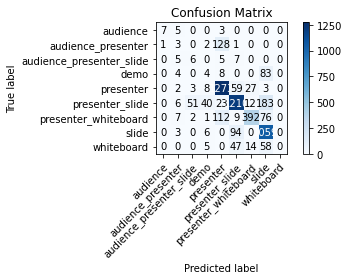

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/accuracy': tensor(0.7723, dtype=torch.float64),
 'test/f_score': tensor(0.8261, dtype=torch.float64),
 'test/loss': tensor(0.7333, device='cuda:0'),
 'test/precision': tensor(0.9331, dtype=torch.float64),
 'test/recall': tensor(0.7723, dtype=torch.float64),
 'test_accuracy': tensor(0.7723, dtype=torch.float64),
 'test_loss': tensor(0.7333, device='cuda:0')}
--------------------------------------------------------------------------------

Split 0 testing completed
Accuracy %s 0.772265625
Training split 1/3


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


wandb: Waiting for W&B process to finish, PID 460
wandb: Program ended successfully.
wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20200922_050756-13ypvn5n/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20200922_050756-13ypvn5n/logs/debug-internal.log
wandb: Run summary:
wandb:       global_step 1640
wandb:        train/loss 0.17365185916423798
wandb:    train/accuracy 0.953125
wandb:   train/precision 0.9417613636363635
wandb:      train/recall 0.953125
wandb:     train/f_score 0.9446657509157509
wandb:             epoch 9
wandb:             _step 30
wandb:          _runtime 2224
wandb:        _timestamp 1600753501
wandb:         test/loss 0.7333426475524902
wandb:     test/accuracy 0.772265625
wandb:    test/precision 0.9330505122621965
wandb:       test/recall 0.772265625
wandb:      test/f_score 0.8261177682003182
wandb: Run history:
wandb:       global_step ▁▁▁▂▂▂▂▃▃▃▃▄▄▄


  | Name                 | Type             | Params
----------------------------------------------------------
0 | criterion            | CrossEntropyLoss | 0     
1 | classification_model | Sequential       | 21 M  
INFO:lightning:
  | Name                 | Type             | Params
----------------------------------------------------------
0 | criterion            | CrossEntropyLoss | 0     
1 | classification_model | Sequential       | 21 M  


Saving latest checkpoint..
INFO:lightning:Saving latest checkpoint..



Completed training split 1, Starting testing


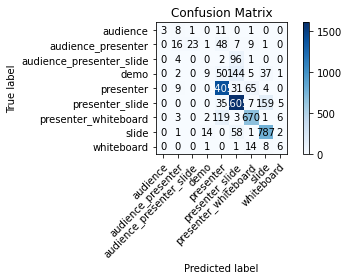

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/accuracy': tensor(0.8180, dtype=torch.float64),
 'test/f_score': tensor(0.8617, dtype=torch.float64),
 'test/loss': tensor(0.6035, device='cuda:0'),
 'test/precision': tensor(0.9518, dtype=torch.float64),
 'test/recall': tensor(0.8180, dtype=torch.float64),
 'test_accuracy': tensor(0.8180, dtype=torch.float64),
 'test_loss': tensor(0.6035, device='cuda:0')}
--------------------------------------------------------------------------------

Split 1 testing completed
Accuracy %s 0.8179798855963991
Training split 2/3


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


wandb: Waiting for W&B process to finish, PID 1416
wandb: Program ended successfully.
wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20200922_054502-11a5eck3/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20200922_054502-11a5eck3/logs/debug-internal.log
wandb: Run summary:
wandb:       global_step 1570
wandb:        train/loss 0.30209705233573914
wandb:    train/accuracy 0.9375
wandb:   train/precision 0.9397701539855073
wandb:      train/recall 0.9375
wandb:     train/f_score 0.9353495345506624
wandb:             epoch 9
wandb:             _step 30
wandb:          _runtime 2186
wandb:        _timestamp 1600755692
wandb:         test/loss 0.6035149097442627
wandb:     test/accuracy 0.8179798855963991
wandb:    test/precision 0.9517768527664829
wandb:       test/recall 0.8179798855963991
wandb:      test/f_score 0.8617499089194527
wandb: Run history:
wandb:       global_step ▁▁▁


  | Name                 | Type             | Params
----------------------------------------------------------
0 | criterion            | CrossEntropyLoss | 0     
1 | classification_model | Sequential       | 21 M  
INFO:lightning:
  | Name                 | Type             | Params
----------------------------------------------------------
0 | criterion            | CrossEntropyLoss | 0     
1 | classification_model | Sequential       | 21 M  


Saving latest checkpoint..
INFO:lightning:Saving latest checkpoint..



Completed training split 2, Starting testing


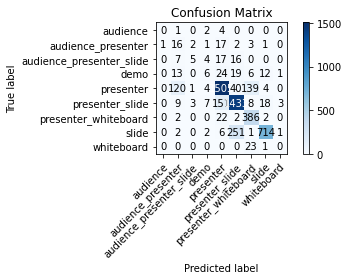

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/accuracy': tensor(0.8052, dtype=torch.float64),
 'test/f_score': tensor(0.8495, dtype=torch.float64),
 'test/loss': tensor(0.5833, device='cuda:0'),
 'test/precision': tensor(0.9730, dtype=torch.float64),
 'test/recall': tensor(0.8052, dtype=torch.float64),
 'test_accuracy': tensor(0.8052, dtype=torch.float64),
 'test_loss': tensor(0.5833, device='cuda:0')}
--------------------------------------------------------------------------------

Split 2 testing completed
Accuracy %s 0.8052478902953587


[I 2020-09-22 07:02:18,500] Trial 25 finished with value: 0.7984978002972526 and parameters: {'hparams_arch': 'resnet34', 'learning_rate': 6.846815440143394e-05, 'max_epochs': 10, 'momentum': 0.9267544652130805, 'optimizer_selection': 'ranger', 'optimizer_alpha': 0.9910390527187658, 'optimizer_eps': 1.2097050621516038e-07, 'ranger_k': 8, 'use_scheduler': 'onecycle', 'optimizer__weight_decay': 0.09120818842570284}. Best is trial 5 with value: 0.8404252485935962.


Training split 0/3


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


wandb: Waiting for W&B process to finish, PID 2364
wandb: Program ended successfully.
wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20200922_062133-2q4792ax/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20200922_062133-2q4792ax/logs/debug-internal.log
wandb: Run summary:
wandb:       global_step 1640
wandb:        train/loss 0.29487887024879456
wandb:    train/accuracy 0.921875
wandb:   train/precision 0.9261984392419176
wandb:      train/recall 0.921875
wandb:     train/f_score 0.921441926129426
wandb:             epoch 9
wandb:             _step 30
wandb:          _runtime 2433
wandb:        _timestamp 1600758138
wandb:         test/loss 0.583341658115387
wandb:     test/accuracy 0.8052478902953587
wandb:    test/precision 0.972967211673699
wandb:       test/recall 0.8052478902953587
wandb:      test/f_score 0.8494976059900123
wandb: Run history:
wandb:       global_step ▁▁


  | Name                 | Type             | Params
----------------------------------------------------------
0 | criterion            | CrossEntropyLoss | 0     
1 | classification_model | Sequential       | 21 M  
INFO:lightning:
  | Name                 | Type             | Params
----------------------------------------------------------
0 | criterion            | CrossEntropyLoss | 0     
1 | classification_model | Sequential       | 21 M  


Saving latest checkpoint..
INFO:lightning:Saving latest checkpoint..



Completed training split 0, Starting testing


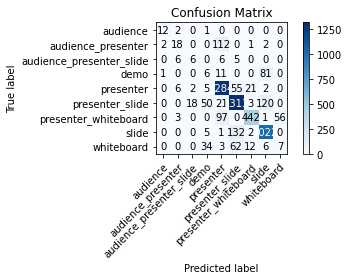

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/accuracy': tensor(0.8150, dtype=torch.float64),
 'test/f_score': tensor(0.8663, dtype=torch.float64),
 'test/loss': tensor(0.9327, device='cuda:0'),
 'test/precision': tensor(0.9774, dtype=torch.float64),
 'test/recall': tensor(0.8150, dtype=torch.float64),
 'test_accuracy': tensor(0.8150, dtype=torch.float64),
 'test_loss': tensor(0.9327, device='cuda:0')}
--------------------------------------------------------------------------------

Split 0 testing completed
Accuracy %s 0.8150390625
Training split 1/3


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


wandb: Waiting for W&B process to finish, PID 3388
wandb: Program ended successfully.
wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20200922_070219-3hbyx0qm/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20200922_070219-3hbyx0qm/logs/debug-internal.log
wandb: Run summary:
wandb:       global_step 1640
wandb:        train/loss 0.005804536864161491
wandb:    train/accuracy 1.0
wandb:   train/precision 1.0
wandb:      train/recall 1.0
wandb:     train/f_score 1.0
wandb:             epoch 9
wandb:             _step 30
wandb:          _runtime 2189
wandb:        _timestamp 1600760332
wandb:         test/loss 0.9326581954956055
wandb:     test/accuracy 0.8150390625
wandb:    test/precision 0.9774284380615453
wandb:       test/recall 0.8150390625
wandb:      test/f_score 0.8663320924583969
wandb: Run history:
wandb:       global_step ▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
wandb:        trai


  | Name                 | Type             | Params
----------------------------------------------------------
0 | criterion            | CrossEntropyLoss | 0     
1 | classification_model | Sequential       | 21 M  
INFO:lightning:
  | Name                 | Type             | Params
----------------------------------------------------------
0 | criterion            | CrossEntropyLoss | 0     
1 | classification_model | Sequential       | 21 M  


Saving latest checkpoint..
INFO:lightning:Saving latest checkpoint..



Completed training split 1, Starting testing


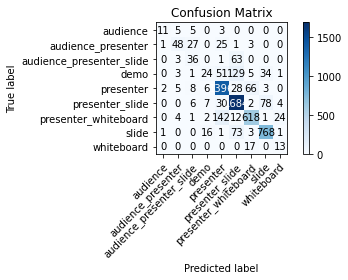

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/accuracy': tensor(0.8356, dtype=torch.float64),
 'test/f_score': tensor(0.8853, dtype=torch.float64),
 'test/loss': tensor(0.7346, device='cuda:0'),
 'test/precision': tensor(0.9767, dtype=torch.float64),
 'test/recall': tensor(0.8356, dtype=torch.float64),
 'test_accuracy': tensor(0.8356, dtype=torch.float64),
 'test_loss': tensor(0.7346, device='cuda:0')}
--------------------------------------------------------------------------------

Split 1 testing completed
Accuracy %s 0.8356210146286571
Training split 2/3


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


wandb: Waiting for W&B process to finish, PID 4330
wandb: Program ended successfully.
wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20200922_073853-21wopi3h/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20200922_073853-21wopi3h/logs/debug-internal.log
wandb: Run summary:
wandb:       global_step 1570
wandb:        train/loss 0.012040575966238976
wandb:    train/accuracy 1.0
wandb:   train/precision 1.0
wandb:      train/recall 1.0
wandb:     train/f_score 1.0
wandb:             epoch 9
wandb:             _step 30
wandb:          _runtime 2113
wandb:        _timestamp 1600762450
wandb:         test/loss 0.7345603108406067
wandb:     test/accuracy 0.8356210146286571
wandb:    test/precision 0.9767469703261855
wandb:       test/recall 0.8356210146286571
wandb:      test/f_score 0.8853178160740356
wandb: Run history:
wandb:       global_step ▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
wandb:


  | Name                 | Type             | Params
----------------------------------------------------------
0 | criterion            | CrossEntropyLoss | 0     
1 | classification_model | Sequential       | 21 M  
INFO:lightning:
  | Name                 | Type             | Params
----------------------------------------------------------
0 | criterion            | CrossEntropyLoss | 0     
1 | classification_model | Sequential       | 21 M  


Saving latest checkpoint..
INFO:lightning:Saving latest checkpoint..



Completed training split 2, Starting testing


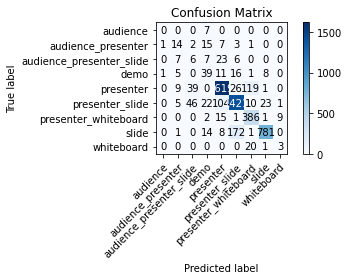

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/accuracy': tensor(0.8459, dtype=torch.float64),
 'test/f_score': tensor(0.8941, dtype=torch.float64),
 'test/loss': tensor(0.6339, device='cuda:0'),
 'test/precision': tensor(0.9928, dtype=torch.float64),
 'test/recall': tensor(0.8459, dtype=torch.float64),
 'test_accuracy': tensor(0.8459, dtype=torch.float64),
 'test_loss': tensor(0.6339, device='cuda:0')}
--------------------------------------------------------------------------------

Split 2 testing completed
Accuracy %s 0.8459256329113924


[I 2020-09-22 08:53:24,838] Trial 26 finished with value: 0.8321952366800165 and parameters: {'hparams_arch': 'resnet34', 'learning_rate': 0.0019167237406032224, 'max_epochs': 10, 'momentum': 0.9453726320082827, 'optimizer_selection': 'adamw', 'optimizer_alpha': 0.9919344645112853, 'optimizer_eps': 1.937490863915898e-08, 'ranger_k': 6, 'use_scheduler': 'onecycle', 'optimizer__weight_decay': 0.00011347478128751792}. Best is trial 5 with value: 0.8404252485935962.


Training split 0/3


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


wandb: Waiting for W&B process to finish, PID 5251
wandb: Program ended successfully.
wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20200922_081411-bzzqdrhr/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20200922_081411-bzzqdrhr/logs/debug-internal.log
wandb: Run summary:
wandb:       global_step 1640
wandb:        train/loss 0.10597189515829086
wandb:    train/accuracy 0.953125
wandb:   train/precision 0.9717447916666666
wandb:      train/recall 0.953125
wandb:     train/f_score 0.9598545573704376
wandb:             epoch 9
wandb:             _step 30
wandb:          _runtime 2349
wandb:        _timestamp 1600764804
wandb:         test/loss 0.6338534951210022
wandb:     test/accuracy 0.8459256329113924
wandb:    test/precision 0.9928069252980123
wandb:       test/recall 0.8459256329113924
wandb:      test/f_score 0.8941079045836098
wandb: Run history:
wandb:       global_step


  | Name                 | Type             | Params
----------------------------------------------------------
0 | criterion            | CrossEntropyLoss | 0     
1 | classification_model | Sequential       | 21 M  
INFO:lightning:
  | Name                 | Type             | Params
----------------------------------------------------------
0 | criterion            | CrossEntropyLoss | 0     
1 | classification_model | Sequential       | 21 M  


Saving latest checkpoint..
INFO:lightning:Saving latest checkpoint..



Completed training split 0, Starting testing


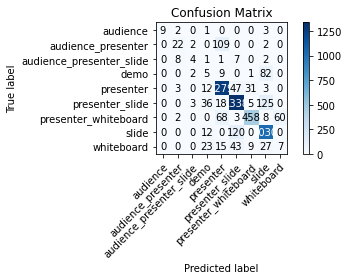

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/accuracy': tensor(0.8109, dtype=torch.float64),
 'test/f_score': tensor(0.8595, dtype=torch.float64),
 'test/loss': tensor(0.8766, device='cuda:0'),
 'test/precision': tensor(0.9759, dtype=torch.float64),
 'test/recall': tensor(0.8109, dtype=torch.float64),
 'test_accuracy': tensor(0.8109, dtype=torch.float64),
 'test_loss': tensor(0.8766, device='cuda:0')}
--------------------------------------------------------------------------------

Split 0 testing completed
Accuracy %s 0.8109375
Training split 1/3


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


wandb: Waiting for W&B process to finish, PID 6237
wandb: Program ended successfully.
wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20200922_085325-w2kwxm7a/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20200922_085325-w2kwxm7a/logs/debug-internal.log
wandb: Run summary:
wandb:       global_step 1640
wandb:        train/loss 0.01862502284348011
wandb:    train/accuracy 1.0
wandb:   train/precision 1.0
wandb:      train/recall 1.0
wandb:     train/f_score 1.0
wandb:             epoch 9
wandb:             _step 30
wandb:          _runtime 2153
wandb:        _timestamp 1600766962
wandb:         test/loss 0.8766061663627625
wandb:     test/accuracy 0.8109375
wandb:    test/precision 0.9759390945298574
wandb:       test/recall 0.8109375
wandb:      test/f_score 0.8594847971289002
wandb: Run history:
wandb:       global_step ▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
wandb:        train/loss 


  | Name                 | Type             | Params
----------------------------------------------------------
0 | criterion            | CrossEntropyLoss | 0     
1 | classification_model | Sequential       | 21 M  
INFO:lightning:
  | Name                 | Type             | Params
----------------------------------------------------------
0 | criterion            | CrossEntropyLoss | 0     
1 | classification_model | Sequential       | 21 M  


Saving latest checkpoint..
INFO:lightning:Saving latest checkpoint..



Completed training split 1, Starting testing


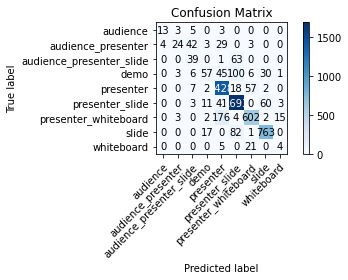

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/accuracy': tensor(0.8401, dtype=torch.float64),
 'test/f_score': tensor(0.8897, dtype=torch.float64),
 'test/loss': tensor(0.6645, device='cuda:0'),
 'test/precision': tensor(0.9887, dtype=torch.float64),
 'test/recall': tensor(0.8401, dtype=torch.float64),
 'test_accuracy': tensor(0.8401, dtype=torch.float64),
 'test_loss': tensor(0.6645, device='cuda:0')}
--------------------------------------------------------------------------------

Split 1 testing completed
Accuracy %s 0.8400986965491373
Training split 2/3


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


wandb: Waiting for W&B process to finish, PID 7165
wandb: Program ended successfully.
wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20200922_092923-3lop7r6b/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20200922_092923-3lop7r6b/logs/debug-internal.log
wandb: Run summary:
wandb:       global_step 1570
wandb:        train/loss 0.013712814077734947
wandb:    train/accuracy 1.0
wandb:   train/precision 1.0
wandb:      train/recall 1.0
wandb:     train/f_score 1.0
wandb:             epoch 9
wandb:             _step 30
wandb:          _runtime 2184
wandb:        _timestamp 1600769151
wandb:         test/loss 0.6645253896713257
wandb:     test/accuracy 0.8400986965491373
wandb:    test/precision 0.9887118366898181
wandb:       test/recall 0.8400986965491373
wandb:      test/f_score 0.889666342284733
wandb: Run history:
wandb:       global_step ▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
wandb: 


  | Name                 | Type             | Params
----------------------------------------------------------
0 | criterion            | CrossEntropyLoss | 0     
1 | classification_model | Sequential       | 21 M  
INFO:lightning:
  | Name                 | Type             | Params
----------------------------------------------------------
0 | criterion            | CrossEntropyLoss | 0     
1 | classification_model | Sequential       | 21 M  


Saving latest checkpoint..
INFO:lightning:Saving latest checkpoint..



Completed training split 2, Starting testing


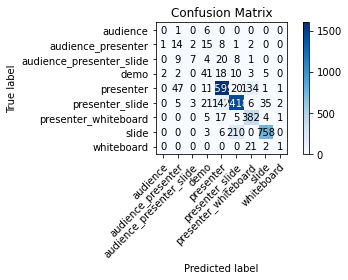

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/accuracy': tensor(0.8360, dtype=torch.float64),
 'test/f_score': tensor(0.8855, dtype=torch.float64),
 'test/loss': tensor(0.6569, device='cuda:0'),
 'test/precision': tensor(0.9922, dtype=torch.float64),
 'test/recall': tensor(0.8360, dtype=torch.float64),
 'test_accuracy': tensor(0.8360, dtype=torch.float64),
 'test_loss': tensor(0.6569, device='cuda:0')}
--------------------------------------------------------------------------------

Split 2 testing completed
Accuracy %s 0.8360363924050633


[I 2020-09-22 10:48:00,290] Trial 27 finished with value: 0.8290241963180668 and parameters: {'hparams_arch': 'resnet34', 'learning_rate': 0.002626036986671875, 'max_epochs': 10, 'momentum': 0.9486785581990225, 'optimizer_selection': 'adamw', 'optimizer_alpha': 0.9962251145544744, 'optimizer_eps': 1.4282804340260273e-08, 'ranger_k': 3, 'use_scheduler': 'onecycle', 'optimizer__weight_decay': 0.03485525587177365}. Best is trial 5 with value: 0.8404252485935962.


Training split 0/3


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


wandb: Waiting for W&B process to finish, PID 8104
wandb: Program ended successfully.
wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20200922_100552-36yn7jqb/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20200922_100552-36yn7jqb/logs/debug-internal.log
wandb: Run summary:
wandb:       global_step 1640
wandb:        train/loss 0.03202836960554123
wandb:    train/accuracy 0.984375
wandb:   train/precision 0.9854910714285714
wandb:      train/recall 0.984375
wandb:     train/f_score 0.9831018518518518
wandb:             epoch 9
wandb:             _step 30
wandb:          _runtime 2524
wandb:        _timestamp 1600771680
wandb:         test/loss 0.6569417119026184
wandb:     test/accuracy 0.8360363924050633
wandb:    test/precision 0.9921656961363967
wandb:       test/recall 0.8360363924050633
wandb:      test/f_score 0.8854644656053573
wandb: Run history:
wandb:       global_step


  | Name                 | Type             | Params
----------------------------------------------------------
0 | criterion            | CrossEntropyLoss | 0     
1 | classification_model | Sequential       | 21 M  
INFO:lightning:
  | Name                 | Type             | Params
----------------------------------------------------------
0 | criterion            | CrossEntropyLoss | 0     
1 | classification_model | Sequential       | 21 M  


Saving latest checkpoint..
INFO:lightning:Saving latest checkpoint..



Completed training split 0, Starting testing


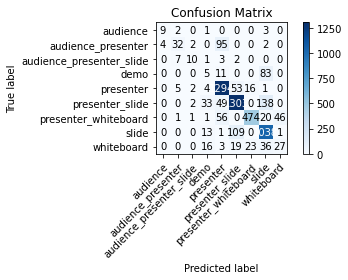

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/accuracy': tensor(0.8311, dtype=torch.float64),
 'test/f_score': tensor(0.8808, dtype=torch.float64),
 'test/loss': tensor(0.7453, device='cuda:0'),
 'test/precision': tensor(0.9887, dtype=torch.float64),
 'test/recall': tensor(0.8311, dtype=torch.float64),
 'test_accuracy': tensor(0.8311, dtype=torch.float64),
 'test_loss': tensor(0.7453, device='cuda:0')}
--------------------------------------------------------------------------------

Split 0 testing completed
Accuracy %s 0.8310546875
Training split 1/3


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


wandb: Waiting for W&B process to finish, PID 9150
wandb: Program ended successfully.
wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20200922_104801-2q1aqq2e/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20200922_104801-2q1aqq2e/logs/debug-internal.log
wandb: Run summary:
wandb:       global_step 1312
wandb:        train/loss 0.050754331052303314
wandb:    train/accuracy 0.96875
wandb:   train/precision 0.9661458333333333
wandb:      train/recall 0.96875
wandb:     train/f_score 0.9646929824561403
wandb:             epoch 7
wandb:             _step 24
wandb:          _runtime 1798
wandb:        _timestamp 1600773483
wandb:         test/loss 0.7453049421310425
wandb:     test/accuracy 0.8310546875
wandb:    test/precision 0.988723168369701
wandb:       test/recall 0.8310546875
wandb:      test/f_score 0.880828164415821
wandb: Run history:
wandb:       global_step ▁▁▂▂▂▂▃▃▃▄▄▄▅▅


  | Name                 | Type             | Params
----------------------------------------------------------
0 | criterion            | CrossEntropyLoss | 0     
1 | classification_model | Sequential       | 21 M  
INFO:lightning:
  | Name                 | Type             | Params
----------------------------------------------------------
0 | criterion            | CrossEntropyLoss | 0     
1 | classification_model | Sequential       | 21 M  


Saving latest checkpoint..
INFO:lightning:Saving latest checkpoint..



Completed training split 1, Starting testing


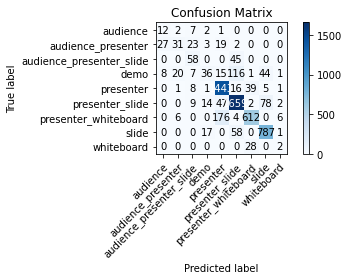

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/accuracy': tensor(0.8432, dtype=torch.float64),
 'test/f_score': tensor(0.8931, dtype=torch.float64),
 'test/loss': tensor(0.7233, device='cuda:0'),
 'test/precision': tensor(0.9926, dtype=torch.float64),
 'test/recall': tensor(0.8432, dtype=torch.float64),
 'test_accuracy': tensor(0.8432, dtype=torch.float64),
 'test_loss': tensor(0.7233, device='cuda:0')}
--------------------------------------------------------------------------------

Split 1 testing completed
Accuracy %s 0.843187359339835
Training split 2/3


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


wandb: Waiting for W&B process to finish, PID 9928
wandb: Program ended successfully.
wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20200922_111803-3gaepx25/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20200922_111803-3gaepx25/logs/debug-internal.log
wandb: Run summary:
wandb:       global_step 1256
wandb:        train/loss 0.06864716112613678
wandb:    train/accuracy 0.984375
wandb:   train/precision 0.9851973684210527
wandb:      train/recall 0.984375
wandb:     train/f_score 0.9842464747356052
wandb:             epoch 7
wandb:             _step 24
wandb:          _runtime 1686
wandb:        _timestamp 1600775173
wandb:         test/loss 0.7233362197875977
wandb:     test/accuracy 0.843187359339835
wandb:    test/precision 0.9925998110954507
wandb:       test/recall 0.843187359339835
wandb:      test/f_score 0.893075997421004
wandb: Run history:
wandb:       global_step ▁▁


  | Name                 | Type             | Params
----------------------------------------------------------
0 | criterion            | CrossEntropyLoss | 0     
1 | classification_model | Sequential       | 21 M  
INFO:lightning:
  | Name                 | Type             | Params
----------------------------------------------------------
0 | criterion            | CrossEntropyLoss | 0     
1 | classification_model | Sequential       | 21 M  


Saving latest checkpoint..
INFO:lightning:Saving latest checkpoint..



Completed training split 2, Starting testing


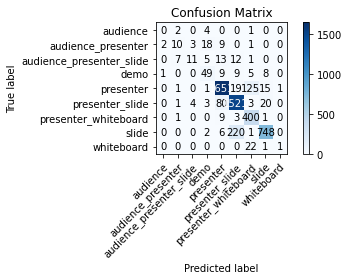

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/accuracy': tensor(0.8697, dtype=torch.float64),
 'test/f_score': tensor(0.9076, dtype=torch.float64),
 'test/loss': tensor(0.4837, device='cuda:0'),
 'test/precision': tensor(0.9914, dtype=torch.float64),
 'test/recall': tensor(0.8697, dtype=torch.float64),
 'test_accuracy': tensor(0.8697, dtype=torch.float64),
 'test_loss': tensor(0.4837, device='cuda:0')}
--------------------------------------------------------------------------------

Split 2 testing completed
Accuracy %s 0.8696598101265823


[I 2020-09-22 12:19:50,669] Trial 28 finished with value: 0.8479672856554724 and parameters: {'hparams_arch': 'resnet34', 'learning_rate': 0.008375362168966284, 'max_epochs': 8, 'momentum': 0.9489740824636609, 'optimizer_selection': 'adamw', 'optimizer_alpha': 0.9919001540796512, 'optimizer_eps': 4.654492552687734e-06, 'ranger_k': 7, 'use_scheduler': 'onecycle', 'optimizer__weight_decay': 0.0062049311351181765}. Best is trial 28 with value: 0.8479672856554724.


Training split 0/3


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


wandb: Waiting for W&B process to finish, PID 10667
wandb: Program ended successfully.
wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20200922_114614-1o57abgp/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20200922_114614-1o57abgp/logs/debug-internal.log
wandb: Run summary:
wandb:       global_step 1312
wandb:        train/loss 0.0235196091234684
wandb:    train/accuracy 0.984375
wandb:   train/precision 0.9852941176470589
wandb:      train/recall 0.984375
wandb:     train/f_score 0.9844300563777308
wandb:             epoch 7
wandb:             _step 24
wandb:          _runtime 2012
wandb:        _timestamp 1600777190
wandb:         test/loss 0.48366233706474304
wandb:     test/accuracy 0.8696598101265823
wandb:    test/precision 0.9913679367397722
wandb:       test/recall 0.8696598101265823
wandb:      test/f_score 0.9076261470778436
wandb: Run history:
wandb:       global_ste


  | Name                 | Type             | Params
----------------------------------------------------------
0 | criterion            | CrossEntropyLoss | 0     
1 | classification_model | Sequential       | 21 M  
INFO:lightning:
  | Name                 | Type             | Params
----------------------------------------------------------
0 | criterion            | CrossEntropyLoss | 0     
1 | classification_model | Sequential       | 21 M  


Saving latest checkpoint..
INFO:lightning:Saving latest checkpoint..



Completed training split 0, Starting testing


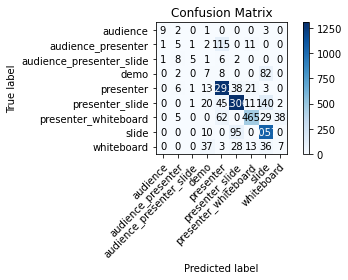

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/accuracy': tensor(0.8113, dtype=torch.float64),
 'test/f_score': tensor(0.8554, dtype=torch.float64),
 'test/loss': tensor(0.8243, device='cuda:0'),
 'test/precision': tensor(0.9609, dtype=torch.float64),
 'test/recall': tensor(0.8113, dtype=torch.float64),
 'test_accuracy': tensor(0.8113, dtype=torch.float64),
 'test_loss': tensor(0.8243, device='cuda:0')}
--------------------------------------------------------------------------------

Split 0 testing completed
Accuracy %s 0.811328125
Training split 1/3


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


wandb: Waiting for W&B process to finish, PID 11381
wandb: Program ended successfully.
wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20200922_121951-we0fbac9/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20200922_121951-we0fbac9/logs/debug-internal.log
wandb: Run summary:
wandb:       global_step 1312
wandb:        train/loss 0.028103478252887726
wandb:    train/accuracy 0.984375
wandb:   train/precision 0.9854910714285714
wandb:      train/recall 0.984375
wandb:     train/f_score 0.9844981284475965
wandb:             epoch 7
wandb:             _step 24
wandb:          _runtime 1932
wandb:        _timestamp 1600779127
wandb:         test/loss 0.8242538571357727
wandb:     test/accuracy 0.811328125
wandb:    test/precision 0.9608892131912572
wandb:       test/recall 0.811328125
wandb:      test/f_score 0.8554482356861856
wandb: Run history:
wandb:       global_step ▁▁▂▂▂▂▃▃▃▄▄


  | Name                 | Type             | Params
----------------------------------------------------------
0 | criterion            | CrossEntropyLoss | 0     
1 | classification_model | Sequential       | 21 M  
INFO:lightning:
  | Name                 | Type             | Params
----------------------------------------------------------
0 | criterion            | CrossEntropyLoss | 0     
1 | classification_model | Sequential       | 21 M  


Saving latest checkpoint..
INFO:lightning:Saving latest checkpoint..



Completed training split 1, Starting testing


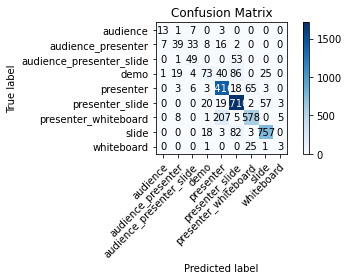

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/accuracy': tensor(0.8428, dtype=torch.float64),
 'test/f_score': tensor(0.8955, dtype=torch.float64),
 'test/loss': tensor(0.6766, device='cuda:0'),
 'test/precision': tensor(0.9924, dtype=torch.float64),
 'test/recall': tensor(0.8428, dtype=torch.float64),
 'test_accuracy': tensor(0.8428, dtype=torch.float64),
 'test_loss': tensor(0.6766, device='cuda:0')}
--------------------------------------------------------------------------------

Split 1 testing completed
Accuracy %s 0.8428005438859715
Training split 2/3


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


wandb: Waiting for W&B process to finish, PID 11640
wandb: Program ended successfully.
wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20200922_125208-3kb2zc18/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20200922_125208-3kb2zc18/logs/debug-internal.log
wandb: Run summary:
wandb:       global_step 1256
wandb:        train/loss 0.08204605430364609
wandb:    train/accuracy 0.96875
wandb:   train/precision 0.984375
wandb:      train/recall 0.96875
wandb:     train/f_score 0.9733573717948718
wandb:             epoch 7
wandb:             _step 24
wandb:          _runtime 1816
wandb:        _timestamp 1600780948
wandb:         test/loss 0.6766358017921448
wandb:     test/accuracy 0.8428005438859715
wandb:    test/precision 0.9924438252954388
wandb:       test/recall 0.8428005438859715
wandb:      test/f_score 0.8954908494681999
wandb: Run history:
wandb:       global_step ▁▁▂▂▂▂▃▃▃▄


  | Name                 | Type             | Params
----------------------------------------------------------
0 | criterion            | CrossEntropyLoss | 0     
1 | classification_model | Sequential       | 21 M  
INFO:lightning:
  | Name                 | Type             | Params
----------------------------------------------------------
0 | criterion            | CrossEntropyLoss | 0     
1 | classification_model | Sequential       | 21 M  


Saving latest checkpoint..
INFO:lightning:Saving latest checkpoint..



Completed training split 2, Starting testing


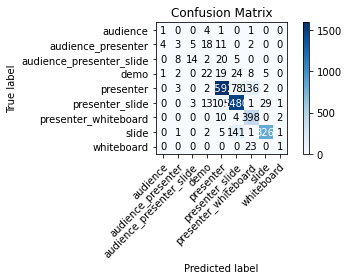

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/accuracy': tensor(0.8592, dtype=torch.float64),
 'test/f_score': tensor(0.8975, dtype=torch.float64),
 'test/loss': tensor(0.4996, device='cuda:0'),
 'test/precision': tensor(0.9891, dtype=torch.float64),
 'test/recall': tensor(0.8592, dtype=torch.float64),
 'test_accuracy': tensor(0.8592, dtype=torch.float64),
 'test_loss': tensor(0.4996, device='cuda:0')}
--------------------------------------------------------------------------------

Split 2 testing completed
Accuracy %s 0.8591772151898734


[I 2020-09-22 13:54:21,854] Trial 29 finished with value: 0.8377686280252816 and parameters: {'hparams_arch': 'resnet34', 'learning_rate': 0.009610594942741808, 'max_epochs': 8, 'momentum': 0.9465348890676148, 'optimizer_selection': 'adamw', 'optimizer_alpha': 0.9922133236315933, 'optimizer_eps': 8.465921889409113e-06, 'ranger_k': 7, 'use_scheduler': 'onecycle', 'optimizer__weight_decay': 0.008463808146777997}. Best is trial 28 with value: 0.8479672856554724.


Training split 0/3


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


wandb: Waiting for W&B process to finish, PID 11897
wandb: Program ended successfully.
wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20200922_132229-p572qqwh/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20200922_132229-p572qqwh/logs/debug-internal.log
wandb: Run summary:
wandb:       global_step 1312
wandb:        train/loss 0.049844689667224884
wandb:    train/accuracy 0.984375
wandb:   train/precision 0.9851973684210527
wandb:      train/recall 0.984375
wandb:     train/f_score 0.9843494062244063
wandb:             epoch 7
wandb:             _step 24
wandb:          _runtime 1908
wandb:        _timestamp 1600782861
wandb:         test/loss 0.4996013939380646
wandb:     test/accuracy 0.8591772151898734
wandb:    test/precision 0.9891417557052765
wandb:       test/recall 0.8591772151898734
wandb:      test/f_score 0.8975069151527428
wandb: Run history:
wandb:       global_st


  | Name                 | Type             | Params
----------------------------------------------------------
0 | criterion            | CrossEntropyLoss | 0     
1 | classification_model | Sequential       | 21 M  
INFO:lightning:
  | Name                 | Type             | Params
----------------------------------------------------------
0 | criterion            | CrossEntropyLoss | 0     
1 | classification_model | Sequential       | 21 M  


Saving latest checkpoint..
INFO:lightning:Saving latest checkpoint..



Completed training split 0, Starting testing


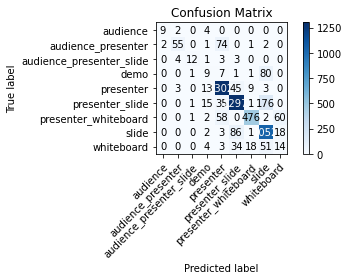

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/accuracy': tensor(0.8377, dtype=torch.float64),
 'test/f_score': tensor(0.8861, dtype=torch.float64),
 'test/loss': tensor(0.7637, device='cuda:0'),
 'test/precision': tensor(0.9896, dtype=torch.float64),
 'test/recall': tensor(0.8377, dtype=torch.float64),
 'test_accuracy': tensor(0.8377, dtype=torch.float64),
 'test_loss': tensor(0.7637, device='cuda:0')}
--------------------------------------------------------------------------------

Split 0 testing completed
Accuracy %s 0.8376953125
Training split 1/3


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


wandb: Waiting for W&B process to finish, PID 12156
wandb: Program ended successfully.
wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20200922_135422-2v8hdlcr/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20200922_135422-2v8hdlcr/logs/debug-internal.log
wandb: Run summary:
wandb:       global_step 1148
wandb:        train/loss 0.08765676617622375
wandb:    train/accuracy 0.984375
wandb:   train/precision 0.98515625
wandb:      train/recall 0.984375
wandb:     train/f_score 0.9838650932400932
wandb:             epoch 6
wandb:             _step 21
wandb:          _runtime 1539
wandb:        _timestamp 1600784405
wandb:         test/loss 0.7636551260948181
wandb:     test/accuracy 0.8376953125
wandb:    test/precision 0.989576899229243
wandb:       test/recall 0.8376953125
wandb:      test/f_score 0.8861407287259215
wandb: Run history:
wandb:       global_step ▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇


  | Name                 | Type             | Params
----------------------------------------------------------
0 | criterion            | CrossEntropyLoss | 0     
1 | classification_model | Sequential       | 21 M  
INFO:lightning:
  | Name                 | Type             | Params
----------------------------------------------------------
0 | criterion            | CrossEntropyLoss | 0     
1 | classification_model | Sequential       | 21 M  


Saving latest checkpoint..
INFO:lightning:Saving latest checkpoint..



Completed training split 1, Starting testing


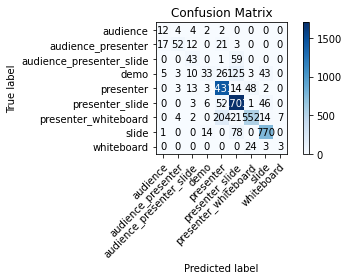

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/accuracy': tensor(0.8357, dtype=torch.float64),
 'test/f_score': tensor(0.8852, dtype=torch.float64),
 'test/loss': tensor(0.6902, device='cuda:0'),
 'test/precision': tensor(0.9918, dtype=torch.float64),
 'test/recall': tensor(0.8357, dtype=torch.float64),
 'test_accuracy': tensor(0.8357, dtype=torch.float64),
 'test_loss': tensor(0.6902, device='cuda:0')}
--------------------------------------------------------------------------------

Split 1 testing completed
Accuracy %s 0.835703066391598
Training split 2/3


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


wandb: Waiting for W&B process to finish, PID 12385
wandb: Program ended successfully.
wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20200922_142006-pubect5j/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20200922_142006-pubect5j/logs/debug-internal.log
wandb: Run summary:
wandb:       global_step 1099
wandb:        train/loss 0.1703774631023407
wandb:    train/accuracy 0.953125
wandb:   train/precision 0.9514399509803922
wandb:      train/recall 0.953125
wandb:     train/f_score 0.9492933262646752
wandb:             epoch 6
wandb:             _step 21
wandb:          _runtime 1492
wandb:        _timestamp 1600785902
wandb:         test/loss 0.6901500821113586
wandb:     test/accuracy 0.835703066391598
wandb:    test/precision 0.9918343097262826
wandb:       test/recall 0.835703066391598
wandb:      test/f_score 0.8852249530838914
wandb: Run history:
wandb:       global_step ▁


  | Name                 | Type             | Params
----------------------------------------------------------
0 | criterion            | CrossEntropyLoss | 0     
1 | classification_model | Sequential       | 21 M  
INFO:lightning:
  | Name                 | Type             | Params
----------------------------------------------------------
0 | criterion            | CrossEntropyLoss | 0     
1 | classification_model | Sequential       | 21 M  


In [ ]:
study.optimize(objective, timeout=12*60*60)